# Full-Sequence Panorama Construction
This notebook extends our 2-image homography example to the complete ordered sequence in a folder.

## Pipeline
1. Load and sort images from a folder.
2. Detect keypoints/descriptors (SIFT).
3. Match descriptors between consecutive pairs using Lowe's ratio test.
4. Estimate pairwise homographies with RANSAC (consecutive frames).
5. Chain homographies to a reference frame (center image) to minimize distortion.
6. Warp all images into the common reference coordinate system.
7. Perform simple Gaussian-weighted blending to form the panorama.

In [1]:
# Global imports and configuration
# !pip install -r ../requirements.txt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pillow_heif import register_heif_opener
register_heif_opener()
from typing import List, Dict
from PIL import Image, ImageOps

plt.rcParams['figure.figsize'] = [15, 10]
np.set_printoptions(precision=3, suppress=True)

### 1. Load, Sort and Resize Images

### Configuration: Feature Detector Selection
Choose between SIFT and ORB feature detectors. SIFT is better for translation scenarios while ORB works well for rotation scenarios.

In [2]:
MAX_WIDTH = 1280
MAX_HEIGHT = 720
# image_folder = '../data/coffee_scene_nopuff/'
image_folder = '../data/coffee_rotate_scene_2/'
# image_folder = '../data/rio_niteroi_scene/'
# image_folder = '../data/teather_scene/'


images: List[np.ndarray] = []
image_names: List[str] = []

print(f'Searching images in: {os.path.abspath(image_folder)}')
for filename in sorted(os.listdir(image_folder)):
    # if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.heic')):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        p = os.path.join(image_folder, filename)
        img = None
        
        # Tenta carregar com OpenCV primeiro (para formatos suportados)
        if not filename.lower().endswith('.heic'):
            img = cv2.imread(p)
        
        # Se OpenCV falhou ou é um arquivo HEIC, tenta com Pillow
        if img is None:
            try:
                pil_img = Image.open(os.path.abspath(p))
                # Corrige orientação baseada em EXIF (importante para HEIC)
                pil_img = ImageOps.exif_transpose(pil_img)
                # Converte para RGB se necessário
                if pil_img.mode != 'RGB':
                    pil_img = pil_img.convert('RGB')
                # Converte PIL para OpenCV (BGR)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            except Exception as e:
                print(f'Falha ao carregar {filename} com Pillow: {e}')
                continue
        
        if img is not None:
            # # Resize keeping aspect ratio, maximizing size for both orientations.
            # # We interpret MAX_WIDTH / MAX_HEIGHT as (max_long_side / max_short_side),
            # # so portrait images can use the larger limit on their height.
            # max_long = max(MAX_WIDTH, MAX_HEIGHT)
            # max_short = min(MAX_WIDTH, MAX_HEIGHT)

            # h, w = img.shape[:2]
            # landscape = w >= h
            # long_side = w if landscape else h
            # short_side = h if landscape else w

            # if long_side > max_long or short_side > max_short:
            #     scale = min(max_long / long_side, max_short / short_side)
            #     new_long = max(1, int(round(long_side * scale)))
            #     new_short = max(1, int(round(short_side * scale)))
            #     if landscape:
            #         new_w, new_h = new_long, new_short
            #     else:
            #         new_w, new_h = new_short, new_long
            #     img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

            images.append(img)
            image_names.append(filename)
        else:
            print(f'Falha ao carregar: {filename}')

# images = images[:5]
print(f'Total de imagens carregadas: {len(images)}')
assert len(images) >= 2, 'At least 2 images are required.'

Searching images in: /files/Doutorado/2025s2/MO446/T1/data/coffee_rotate_scene_2


Total de imagens carregadas: 8


In [3]:
# Configuration: Choose feature detector
# Options: 'SIFT' or 'ORB'
# Set to None for automatic detection based on folder name
DETECTOR_TYPE = None  # Set to 'SIFT' or 'ORB' to force a specific detector

# Automatic detection based on folder name
if DETECTOR_TYPE is None:
    if 'coffee_rotate' in image_folder or 'rio_niteroi_scene' in image_folder:
        DETECTOR_TYPE = 'ORB'
        # print(f"Auto-detected rotation scenario, using {DETECTOR_TYPE}")
    else:
        DETECTOR_TYPE = 'SIFT'
        # print(f"Auto-detected translation scenario, using {DETECTOR_TYPE}")
else:
    print(f"Manual selection: {DETECTOR_TYPE}")

print(f"Final detector selection: {DETECTOR_TYPE}")
print()
print("💡 Tip: For translation scenarios use SIFT, for rotation scenarios use ORB")
print("   You can manually set DETECTOR_TYPE = 'SIFT' or 'ORB' to override auto-detection")

Final detector selection: ORB

💡 Tip: For translation scenarios use SIFT, for rotation scenarios use ORB
   You can manually set DETECTOR_TYPE = 'SIFT' or 'ORB' to override auto-detection


### 2. Detect Local Features (SIFT or ORB)
We extract keypoints using either SIFT or ORB based on the configuration above:
- **SIFT**: Scale- and rotation-invariant, 128-D descriptors. Better for translation scenarios.
- **ORB**: Binary descriptors, faster computation. Works well for rotation scenarios.

Design considerations:
- nfeatures limits max keypoints to control runtime.
- Contrast/edge thresholds could be tuned for low-texture scenes.
- Matcher type depends on descriptor type (FLANN for SIFT, BruteForce for ORB).

In [4]:
# Initialize detector and matcher based on configuration
if DETECTOR_TYPE == 'SIFT':
    # SIFT detector with FLANN matcher
    detector = cv2.SIFT_create(nfeatures=50000)
    
    # FLANN for SIFT descriptors (float32) using KDTree
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    ratio_thresh = 0.45  # Lowe's ratio threshold for SIFT
    
elif DETECTOR_TYPE == 'ORB':
    # ORB detector with BruteForce matcher
    detector = cv2.ORB_create(nfeatures=50000)
    
    # BruteForce matcher for ORB descriptors (binary)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    ratio_thresh = 0.75  # Higher threshold for ORB binary descriptors
    
else:
    raise ValueError(f"Unsupported detector type: {DETECTOR_TYPE}")

print(f"Initialized {DETECTOR_TYPE} detector with appropriate matcher")

Initialized ORB detector with appropriate matcher


In [5]:
def detect_all_features(imgs: List[np.ndarray]) -> List[Dict]:
    """Detect keypoints/descriptors for all images using the configured detector.

    Returns a list of dicts with keys: 'image', 'gray', 'kp', 'desc'.
    """
    data = []
    for i, im in enumerate(imgs):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, desc = detector.detectAndCompute(gray, None)
        data.append({'image': im, 'gray': gray, 'kp': kp, 'desc': desc})
        desc_info = f"{desc.shape} ({desc.dtype})" if desc is not None else "None"
        print(f'Image {i}: {image_names[i]} | keypoints: {len(kp)} | desc: {desc_info}')
    return data

dataset = detect_all_features(images)
print(f'Dataset created with {len(dataset)} images using {DETECTOR_TYPE} detector.')

Image 0: IMG_3205.jpg | keypoints: 43236 | desc: (43236, 32) (uint8)
Image 1: IMG_3206.jpg | keypoints: 41629 | desc: (41629, 32) (uint8)
Image 2: IMG_3207.jpg | keypoints: 35475 | desc: (35475, 32) (uint8)
Image 3: IMG_3208.jpg | keypoints: 39427 | desc: (39427, 32) (uint8)
Image 4: IMG_3209.jpg | keypoints: 35924 | desc: (35924, 32) (uint8)
Image 5: IMG_3210.jpg | keypoints: 29372 | desc: (29372, 32) (uint8)
Image 3: IMG_3208.jpg | keypoints: 39427 | desc: (39427, 32) (uint8)
Image 4: IMG_3209.jpg | keypoints: 35924 | desc: (35924, 32) (uint8)
Image 5: IMG_3210.jpg | keypoints: 29372 | desc: (29372, 32) (uint8)
Image 6: IMG_3211.jpg | keypoints: 33843 | desc: (33843, 32) (uint8)
Image 7: IMG_3212.jpg | keypoints: 35300 | desc: (35300, 32) (uint8)
Dataset created with 8 images using ORB detector.
Image 6: IMG_3211.jpg | keypoints: 33843 | desc: (33843, 32) (uint8)
Image 7: IMG_3212.jpg | keypoints: 35300 | desc: (35300, 32) (uint8)
Dataset created with 8 images using ORB detector.


### 3. Match Consecutive Image Pairs
We perform descriptor matching only between consecutive frames to keep graph topology simple (a path). For each descriptor in image i we retrieve its 2 nearest neighbors in image i+1 and apply Lowe's ratio test.

Rationale:
- Restricting to adjacent images reduces false matches and runtime.
- Full graph matching (all-vs-all) improves robustness for unordered sets but is O(N^2).
- Lowe ratio threshold (typical 0.7–0.9) trades precision vs recall.

In [6]:
K = 2  # Use 2 for standard ratio test (was 3 before)

def match_pair(desc1: np.ndarray, desc2: np.ndarray):
    """Return list of good matches between two descriptor sets using KNN + Lowe ratio test."""
    if desc1 is None or desc2 is None:
        return []
    
    # KNN matching with appropriate matcher
    if DETECTOR_TYPE == 'SIFT':
        # FLANN matcher for SIFT
        knn = matcher.knnMatch(desc1, desc2, k=K)
    else:  # ORB
        # BruteForce matcher for ORB
        knn = matcher.knnMatch(desc1, desc2, k=K)
    
    # Apply Lowe's ratio test
    good = []
    for match_pair in knn:
        if len(match_pair) == 2:  # Ensure we have 2 matches
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
    
    return good

pairs_matches = []
for i in range(len(dataset) - 1):
    m = match_pair(dataset[i]['desc'], dataset[i+1]['desc'])
    print(f'Pair ({i},{i+1}) -> filtered matches: {len(m)}')
    pairs_matches.append(m)

# Quick sanity check
assert all(len(m) >= 4 for m in pairs_matches), 'A pair has insufficient matches (>=4 required) for homography.'

Pair (0,1) -> filtered matches: 11074
Pair (1,2) -> filtered matches: 13779
Pair (1,2) -> filtered matches: 13779
Pair (2,3) -> filtered matches: 11662
Pair (2,3) -> filtered matches: 11662
Pair (3,4) -> filtered matches: 13102
Pair (3,4) -> filtered matches: 13102
Pair (4,5) -> filtered matches: 9879
Pair (4,5) -> filtered matches: 9879
Pair (5,6) -> filtered matches: 6863
Pair (5,6) -> filtered matches: 6863
Pair (6,7) -> filtered matches: 9259
Pair (6,7) -> filtered matches: 9259


### 4. Estimate Pairwise Homographies (RANSAC)
Using the filtered matches for each adjacent pair we compute a projective transform (3x3 homography) with RANSAC to reject outliers.

Parameters:
- ransacReprojThreshold: maximum reprojection error (pixels) to count as inlier.
- maxIters, confidence: control robustness vs speed.

Failure modes:
- Too few inliers (low texture / motion blur).
- Pure rotation + low parallax may still produce valid H but can amplify drift when chaining.

In [7]:
def estimate_homography_between(i: int, j: int):
    """Estimate homography mapping image i to image j (only consecutive supported)."""
    kpA, kpB = dataset[i]['kp'], dataset[j]['kp']
    matches = pairs_matches[i] if j == i+1 else None
    if matches is None:
        raise ValueError('This example only estimates between consecutive pairs.')
    ptsA = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    ptsB = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, inliers = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=2.0, maxIters=50000, confidence=0.9995)
    if H is None:
        raise RuntimeError(f'Failed to estimate H between {i}->{j}')
    nin = int(inliers.sum()) if inliers is not None else 0
    print(f'H {i}->{j} estimated. Inliers: {nin}/{len(matches)}')
    return H

# H_forward[i] maps i -> i+1
H_forward: List[np.ndarray] = []
for i in range(len(dataset) - 1):
    H = estimate_homography_between(i, i+1)
    H = H / H[2,2]
    print(f'H_{i}->{i+1}:{H}')
    H_forward.append(H)

H 0->1 estimated. Inliers: 4365/11074
H_0->1:[[   1.108    0.075 -459.446]
 [   0.021    1.077 -113.455]
 [   0.       0.       1.   ]]
H 1->2 estimated. Inliers: 10425/13779
H_1->2:[[   1.104    0.072 -535.446]
 [   0.002    1.06    11.037]
 [   0.       0.       1.   ]]
H 2->3 estimated. Inliers: 6327/11662
H_2->3:[[   1.062    0.059 -344.431]
 [  -0.012    1.038    0.504]
 [   0.       0.       1.   ]]
H 3->4 estimated. Inliers: 8268/13102
H_3->4:[[   1.094    0.048 -437.884]
 [   0.013    1.066  -61.314]
 [   0.       0.       1.   ]]
H 4->5 estimated. Inliers: 6417/9879
H_4->5:[[   1.136    0.056 -640.834]
 [   0.041    1.087  -98.573]
 [   0.       0.       1.   ]]
H 5->6 estimated. Inliers: 1720/6863
H_5->6:[[   1.145    0.099 -678.718]
 [   0.03     1.09   -30.323]
 [   0.       0.       1.   ]]
H 6->7 estimated. Inliers: 4501/9259
H_6->7:[[   1.115    0.069 -540.618]
 [   0.004    1.08   -57.752]
 [   0.       0.       1.   ]]


### 5. Chain Homographies to a Reference Frame
We choose the middle image as reference to minimize perspective distortion and accumulated drift. For images left of the reference we compose forward homographies; for the right side we compose then invert.

Alternative strategies:
- Global bundle adjustment optimizing all homographies simultaneously.
- Selecting a frame with minimal average distance to others (graph center).

In [8]:
def chain_homographies_to_ref(n: int, ref_idx: int, H_forward: List[np.ndarray]) -> List[np.ndarray]:
    """Return list H_to_ref[k]: homography mapping image k into reference frame ref_idx."""
    I = np.eye(3, dtype=np.float64)
    H_to_ref = [I.copy() for _ in range(n)]
    # For k < ref: multiply forward (k->k+1->...->ref)
    for k in range(ref_idx - 1, -1, -1):
        # H_to_ref[k] = H_forward[k] @ H_to_ref[k+1]
        # H_to_ref[k] = H_forward[k+1] @ H_to_ref[k]
        H_to_ref[k] = H_to_ref[k+1] @ H_forward[k]
        H_to_ref[k] /= H_to_ref[k][2,2]
    # For k > ref: chain ref->...->k then invert
    for k in range(ref_idx + 1, n):
        H_ref_to_k = np.eye(3, dtype=np.float64)
        for t in range(ref_idx, k):
            H_ref_to_k = H_forward[t] @ H_ref_to_k
        H_to_ref[k] = np.linalg.inv(H_ref_to_k)
        H_to_ref[k] /= H_to_ref[k][2,2]
    return H_to_ref

ref_idx = len(dataset) // 2  # central image as reference
H_to_ref = chain_homographies_to_ref(len(dataset), ref_idx, H_forward)
print(f'Reference image: {ref_idx} -> {image_names[ref_idx]}')

Reference image: 4 -> IMG_3209.jpg


#### Computing panorama canvas bounds from warped corners

In [9]:
def compute_panorama_bounds(imgs: List[np.ndarray], H_to_ref: List[np.ndarray]):
    corners_all = []
    for k, img in enumerate(imgs):
        h, w = img.shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        warped = cv2.perspectiveTransform(corners, H_to_ref[k])
        corners_all.append(warped)
    allc = np.vstack(corners_all)
    xmin, ymin = np.floor(allc.min(axis=0).ravel()).astype(int)
    xmax, ymax = np.ceil(allc.max(axis=0).ravel()).astype(int)
    return xmin, ymin, xmax, ymax

xmin, ymin, xmax, ymax = compute_panorama_bounds(images, H_to_ref)
Tx, Ty = -xmin, -ymin
T = np.array([[1,0,Tx],[0,1,Ty],[0,0,1]], dtype=np.float64)
W, Hh = (xmax - xmin), (ymax - ymin)
print(f'Panorama canvas (W x H): {W} x {Hh}')

Panorama canvas (W x H): 7438 x 5245


### 6. Warp Images to Common Reference Frame

In [10]:
folder_name = os.path.basename(os.path.normpath(image_folder))
save_dir = os.path.join('..', 'report', 'figs', 'alignment', folder_name)
os.makedirs(save_dir, exist_ok=True)

print(f'--- Saving progressive alignment figures to: {save_dir} ---')
for k, img in enumerate(images):
    Hk = T @ H_to_ref[k]
    warped_image = cv2.warpPerspective(img, Hk, (W, Hh))
    plt.figure(figsize=(18,10))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Alignment of Image {k}: {image_names[k]}')
    plt.axis('off')
    out_path = os.path.join(save_dir, f'{k:02d}_{os.path.splitext(image_names[k])[0]}.png')
    plt.savefig(out_path, bbox_inches='tight')
    plt.close()
print('Done.')

--- Saving progressive alignment figures to: ../report/figs/alignment/coffee_rotate_scene_2 ---


Done.


### 7. Naive Gaussian Blending

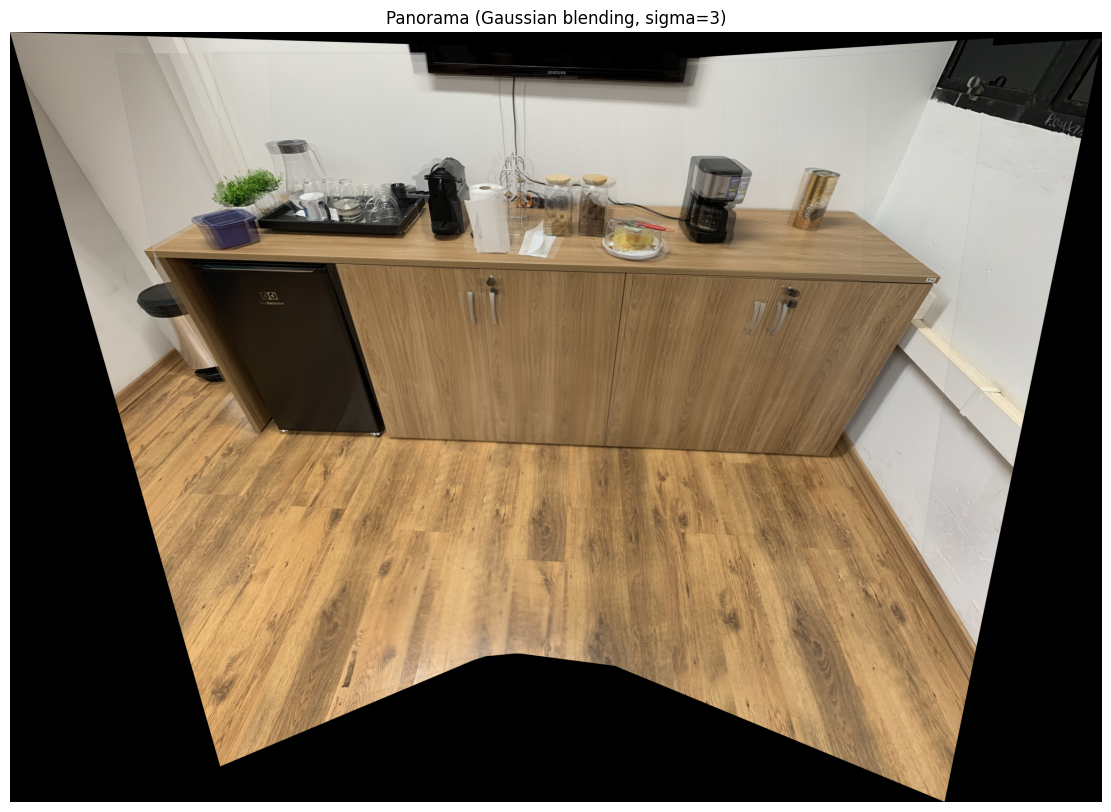

Saved panorama to: ../report/figs/final_pano/coffee_rotate_scene_2/panorama_sigma3.png


In [11]:
SIGMA = 3

# Warp + simple Gaussian-weighted blending
def warp_and_blend(imgs: List[np.ndarray], H_to_ref: List[np.ndarray], T: np.ndarray, size: tuple, sigma: int = 1):
    """Warp all images into panorama canvas and blend with blurred mask weighting."""
    W, Hh = size
    acc = np.zeros((Hh, W, 3), dtype=np.float64)
    wsum = np.zeros((Hh, W, 1), dtype=np.float64)
    for k, img in enumerate(imgs):
        Hk = T @ H_to_ref[k]
        warped = cv2.warpPerspective(img, Hk, (W, Hh))
        mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        warped_mask = cv2.warpPerspective(mask, Hk, (W, Hh))
        weight = warped_mask.astype(np.float32) / 255.0
        if sigma and sigma > 1:
            ksize = (sigma | 1, sigma | 1)  # ensure odd size
            weight = cv2.GaussianBlur(weight, ksize, 0)
        weight = weight[..., None]
        acc += warped.astype(np.float64) * weight
        wsum += weight
    eps = 1e-6
    out = (acc / (wsum + eps)).clip(0, 255).astype(np.uint8)
    return out

panorama = warp_and_blend(images, H_to_ref, T, (W, Hh), sigma=SIGMA)

# Save panorama figure
final_dir = os.path.join('..', 'report', 'figs', 'final_pano', folder_name)
os.makedirs(final_dir, exist_ok=True)
final_path = os.path.join(final_dir, f'panorama_sigma{SIGMA}.png')
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title(f'Panorama (Gaussian blending, sigma={SIGMA})')
plt.axis('off')
plt.savefig(final_path, bbox_inches='tight')
plt.show()
plt.close()
print(f'Saved panorama to: {final_path}')



Saved simple overlay panorama to: ../report/figs/final_pano/coffee_rotate_scene_2/panorama_simple_overlay.png
Saved multi-band panorama to: ../report/figs/final_pano/coffee_rotate_scene_2/panorama_multiband_L6.png
Saved multi-band panorama to: ../report/figs/final_pano/coffee_rotate_scene_2/panorama_multiband_L6.png


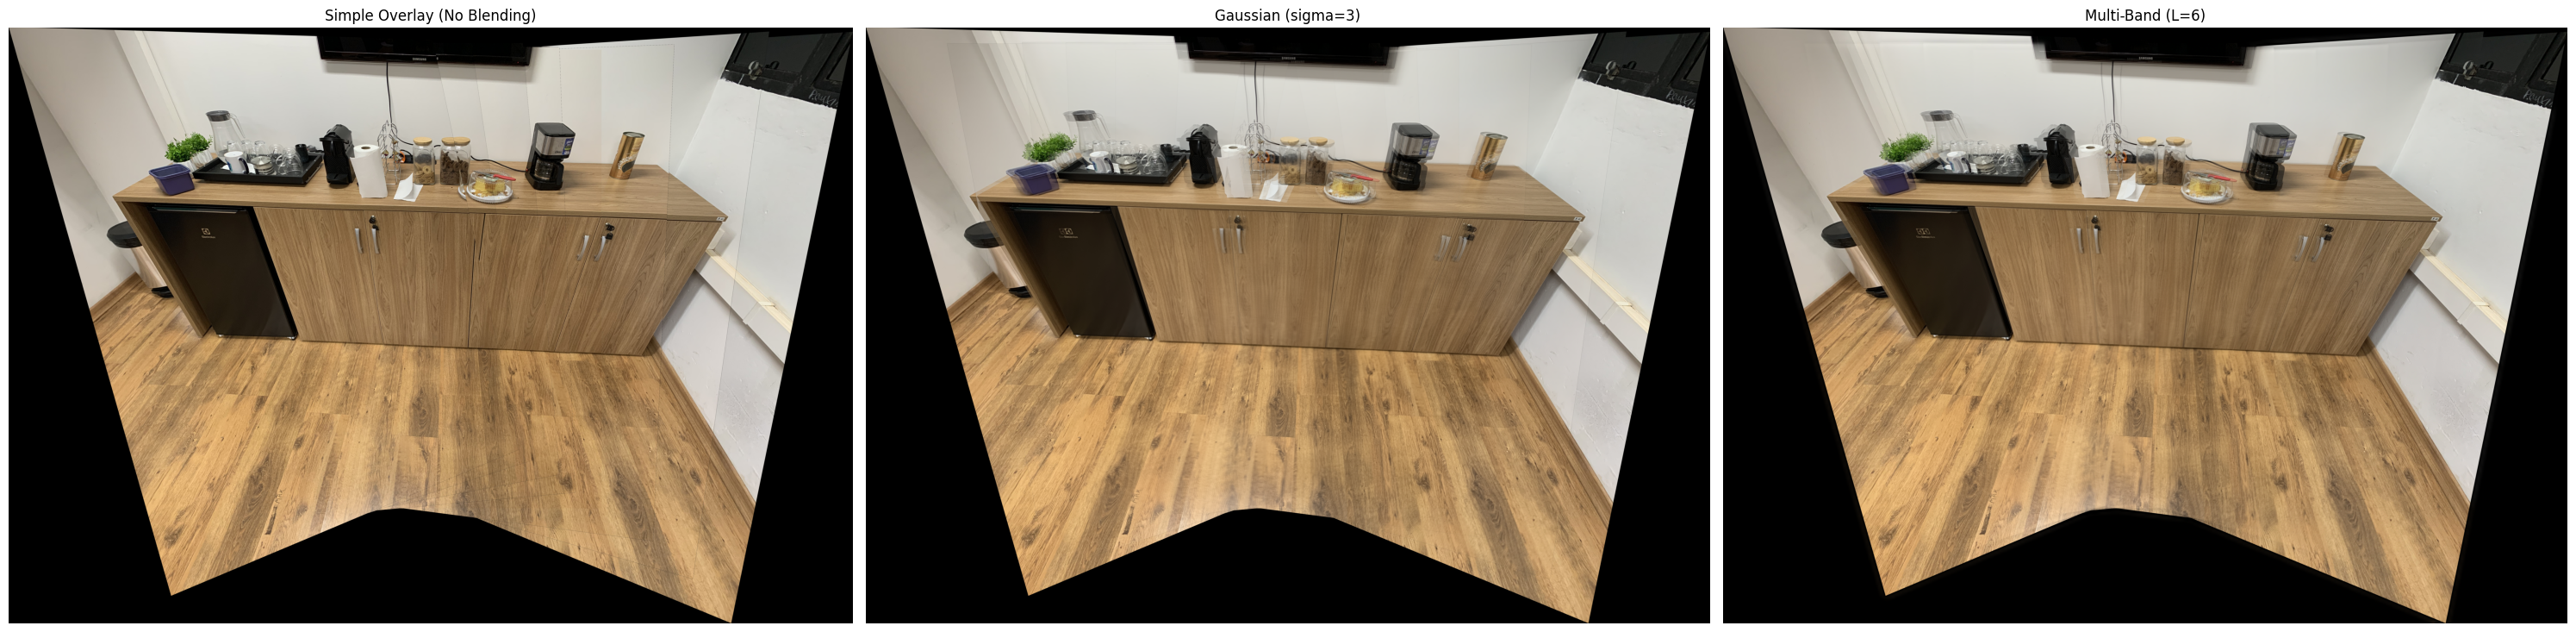

Saved side-by-side triple comparison figure to: ../report/figs/final_pano/coffee_rotate_scene_2/panorama_triple_comparison_side_by_side_L6_sigma3.png


In [12]:
# Advanced Multi-Band (Laplacian Pyramid) Blending
# -------------------------------------------------
# This cell implements a more sophisticated blending approach than the simple
# per-pixel Gaussian weighting used above. We perform multi-band blending by:
# 1. Warping each image (and its mask) into the panorama canvas.
# 2. Building a Laplacian pyramid for each warped image and a Gaussian pyramid for its weight mask.
# 3. Accumulating (weighted sum) Laplacian levels across all images and also
#    accumulating the corresponding weight (mask) pyramids.
# 4. Normalizing each Laplacian level by the accumulated weights.
# 5. Reconstructing the final panorama from the blended Laplacian pyramid.
#
# Advantages:
# - Reduces visible seams where exposure / illumination / slight misalignment occurs.
# - Preserves sharp details while smoothly transitioning low-frequency content.
#
# Notes:
# - This is a generic N-image extension of classic two-image multi-band blending.
# - For speed you can reduce the number of pyramid levels.
# - Exposure compensation is not implemented here but could be added (e.g., gain
#   normalization on overlaps) before building pyramids.

from typing import Tuple

# --- Simple Overlay (baseline, no blending) ---
# We build a naive mosaic where each warped image only fills currently empty pixels.
# This shows seams clearly and serves as a baseline before Gaussian and Multi-band blending.

def simple_overlay_mosaic(imgs: List[np.ndarray], H_to_ref: List[np.ndarray], T: np.ndarray, size: tuple) -> np.ndarray:
    W, Hh = size
    canvas = np.zeros((Hh, W, 3), dtype=np.uint8)
    occupancy = np.zeros((Hh, W), dtype=bool)
    for k, img in enumerate(imgs):
        Hk = T @ H_to_ref[k]
        warped = cv2.warpPerspective(img, Hk, (W, Hh))
        mask = cv2.warpPerspective(np.ones(img.shape[:2], dtype=np.uint8)*255, Hk, (W, Hh))
        valid = mask > 0
        new_pixels = valid & (~occupancy)
        canvas[new_pixels] = warped[new_pixels]
        occupancy |= valid  # Mark filled pixels (no overwriting later)
    return canvas


def build_gaussian_pyramid(img: np.ndarray, levels: int) -> list:
    g = [img]
    for _ in range(1, levels):
        g.append(cv2.pyrDown(g[-1]))
    return g


def build_laplacian_pyramid(img: np.ndarray, levels: int) -> Tuple[list, list]:
    g = build_gaussian_pyramid(img, levels)
    l = []
    for i in range(levels - 1):
        up = cv2.pyrUp(g[i+1], dstsize=(g[i].shape[1], g[i].shape[0]))
        l.append(g[i] - up)
    l.append(g[-1])  # smallest level
    return g, l


def normalize_mask(mask: np.ndarray, ksize: int = 31) -> np.ndarray:
    """Refine mask with distance transform + blur -> smooth feathering.
    mask: uint8 or float mask in [0,1] or [0,255]. Returns float32 in [0,1]."""
    m = mask.astype(np.float32)
    if m.max() > 1.5:
        m /= 255.0
    # Distance transform inside mask
    bin_mask = (m > 0.5).astype(np.uint8)
    if bin_mask.any():
        dist = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 3)
        if dist.max() > 0:
            dist /= dist.max()
            m = m * dist  # emphasize central regions
    if ksize and ksize > 1:
        k = ksize | 1
        m = cv2.GaussianBlur(m, (k, k), 0)
    # Avoid exact zeros to keep weights stable
    return np.clip(m, 1e-6, 1.0)


def multi_band_blend(imgs: List[np.ndarray],
                     H_to_ref: List[np.ndarray],
                     T: np.ndarray,
                     size: Tuple[int, int],
                     levels: int = 5,
                     mask_blur: int = 31) -> np.ndarray:
    """Perform multi-band (Laplacian pyramid) blending for a list of already aligned images.

    Args:
        imgs: original images (BGR)
        H_to_ref: list of homographies mapping each image to reference frame
        T: translation homography to shift into positive panorama coordinates
        size: (W, H) panorama canvas dimensions
        levels: number of pyramid levels (>=2)
        mask_blur: kernel size for mask smoothing / distance feathering

    Returns:
        Blended panorama (uint8, BGR)
    """
    W, Hh = size
    assert levels >= 2, "levels must be >= 2"

    acc_L = None        # list of accumulated Laplacian levels (float32)
    wsum_G = None       # list of accumulated Gaussian mask levels (float32, single channel)

    for idx, img in enumerate(imgs):
        Hk = T @ H_to_ref[idx]
        warped = cv2.warpPerspective(img, Hk, (W, Hh))
        mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        warped_mask = cv2.warpPerspective(mask, Hk, (W, Hh))
        w = normalize_mask(warped_mask, ksize=mask_blur)  # (H, W)

        # Prepare pyramids (convert to float32 for stability)
        warped_f = warped.astype(np.float32)
        g_mask = build_gaussian_pyramid(w, levels)            # list of (H_l, W_l)
        _, lap_img = build_laplacian_pyramid(warped_f, levels) # list of (H_l, W_l, 3)

        if acc_L is None:
            acc_L = [np.zeros_like(Ll, dtype=np.float32) for Ll in lap_img]
            wsum_G = [np.zeros_like(g_mask_l, dtype=np.float32) for g_mask_l in g_mask]

        for l in range(levels):
            # Expand mask to 3 channels for Laplacian weighting
            mask_l = g_mask[l]
            if lap_img[l].ndim == 3:
                mask_3 = mask_l[..., None]
            else:
                mask_3 = mask_l[..., None]
            acc_L[l] += lap_img[l] * mask_3
            wsum_G[l] += mask_l

    # Normalize Laplacian levels
    eps = 1e-6
    blended_L = []
    for l in range(levels):
        denom = wsum_G[l][..., None] + eps
        blended = acc_L[l] / denom
        blended_L.append(blended)

    # Reconstruct image from blended Laplacian pyramid
    current = blended_L[-1]
    for l in reversed(range(levels - 1)):
        up = cv2.pyrUp(current, dstsize=(blended_L[l].shape[1], blended_L[l].shape[0]))
        current = up + blended_L[l]

    pano = np.clip(current, 0, 255).astype(np.uint8)
    return pano

# Execute simple overlay baseline (before fancier blending)
simple_overlay = simple_overlay_mosaic(images, H_to_ref, T, (W, Hh))

# Save simple overlay
baseline_dir = os.path.join('..', 'report', 'figs', 'final_pano', folder_name)
os.makedirs(baseline_dir, exist_ok=True)
baseline_path = os.path.join(baseline_dir, 'panorama_simple_overlay.png')
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(simple_overlay, cv2.COLOR_BGR2RGB))
plt.title('Simple Overlay (No Blending)')
plt.axis('off')
plt.savefig(baseline_path, bbox_inches='tight')
plt.close()
print(f'Saved simple overlay panorama to: {baseline_path}')

# Execute multi-band blending
MULTIBAND_LEVELS = 6  # adjust for speed/quality trade-off (3–6 typical)
panorama_multiband = multi_band_blend(images, H_to_ref, T, (W, Hh), levels=MULTIBAND_LEVELS)

# Save result
advanced_dir = os.path.join('..', 'report', 'figs', 'final_pano', folder_name)
os.makedirs(advanced_dir, exist_ok=True)
mb_path = os.path.join(advanced_dir, f'panorama_multiband_L{MULTIBAND_LEVELS}.png')
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(panorama_multiband, cv2.COLOR_BGR2RGB))
plt.title(f'Multi-Band Blended Panorama (levels={MULTIBAND_LEVELS})')
plt.axis('off')
plt.savefig(mb_path, bbox_inches='tight')
plt.close()
print(f'Saved multi-band panorama to: {mb_path}')

# Triple comparison (side-by-side): Simple Overlay vs Gaussian vs Multi-Band
try:
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    axes[0].imshow(cv2.cvtColor(simple_overlay, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Simple Overlay (No Blending)')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Gaussian (sigma={SIGMA})')
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(panorama_multiband, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Multi-Band (L={MULTIBAND_LEVELS})')
    axes[2].axis('off')

    plt.tight_layout()
    cmp_path = os.path.join(advanced_dir, f'panorama_triple_comparison_side_by_side_L{MULTIBAND_LEVELS}_sigma{SIGMA}.png')
    plt.savefig(cmp_path, bbox_inches='tight')
    plt.show()
    print(f'Saved side-by-side triple comparison figure to: {cmp_path}')
except Exception as e:
    print('Side-by-side triple comparison figure skipped:', e)

## Visualização Progressiva: Construção Cumulativa do Panorama

Esta seção mostra a construção progressiva do panorama, onde cada frame mostra as imagens sendo sobrepostas cumulativamente:
- Frame 0: apenas a primeira imagem
- Frame 1: primeira + segunda imagem
- Frame 2: primeira + segunda + terceira imagem
- E assim por diante...

Isso permite visualizar como o panorama vai sendo construído passo a passo.


In [ ]:
# def create_progressive_panorama(imgs: List[np.ndarray], H_to_ref: List[np.ndarray], T: np.ndarray, 
#                                size: tuple, sigma: int = 1, up_to_frame = None):
#     """
#     Cria panorama progressivo incluindo apenas as primeiras 'up_to_frame' imagens.
    
#     Args:
#         imgs: lista de imagens
#         H_to_ref: homografias para o frame de referência
#         T: matriz de translação para ajustar bounds
#         size: (width, height) do canvas
#         sigma: parâmetro para Gaussian blending
#         up_to_frame: número de imagens a incluir (None = todas)
    
#     Returns:
#         Panorama com apenas as primeiras up_to_frame imagens
#     """
#     if up_to_frame is None:
#         up_to_frame = len(imgs)
    
#     W, Hh = size
#     acc = np.zeros((Hh, W, 3), dtype=np.float64)
#     wsum = np.zeros((Hh, W, 1), dtype=np.float64)
    
#     # Processa apenas as primeiras up_to_frame imagens
#     for k in range(up_to_frame):
#         img = imgs[k]
#         Hk = T @ H_to_ref[k]
#         warped = cv2.warpPerspective(img, Hk, (W, Hh))
#         mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
#         warped_mask = cv2.warpPerspective(mask, Hk, (W, Hh))
#         weight = warped_mask.astype(np.float32) / 255.0
        
#         if sigma and sigma > 1:
#             ksize = (sigma | 1, sigma | 1)  # ensure odd size
#             weight = cv2.GaussianBlur(weight, ksize, 0)
        
#         weight = weight[..., None]
#         acc += warped.astype(np.float64) * weight
#         wsum += weight
    
#     eps = 1e-6
#     out = (acc / (wsum + eps)).clip(0, 255).astype(np.uint8)
#     return out

# # Cria diretório para salvar os frames progressivos
# progressive_dir = os.path.join('..', 'report', 'figs', 'progressive_build', folder_name)
# os.makedirs(progressive_dir, exist_ok=True)

# print(f'--- Criando visualização progressiva do panorama ---')
# print(f'Salvando frames em: {progressive_dir}')

# # Gera e salva cada frame progressivo
# progressive_frames = []
# for frame_idx in range(1, len(images) + 1):  # de 1 a n imagens
#     print(f'Gerando frame {frame_idx}: incluindo primeiras {frame_idx} imagens')
    
#     # Cria panorama progressivo
#     progressive_pano = create_progressive_panorama(
#         images, H_to_ref, T, (W, Hh), sigma=SIGMA, up_to_frame=frame_idx
#     )
#     progressive_frames.append(progressive_pano)
    
#     # Salva o frame
#     frame_path = os.path.join(progressive_dir, f'frame_{frame_idx:02d}_images.png')
#     plt.figure(figsize=(18, 10))
#     plt.imshow(cv2.cvtColor(progressive_pano, cv2.COLOR_BGR2RGB))
#     plt.title(f'Construção Progressiva - Frame {frame_idx}: {frame_idx} imagem(ns)')
#     plt.axis('off')
#     plt.savefig(frame_path, bbox_inches='tight')
#     plt.close()
    
#     print(f'  -> Salvo: {frame_path}')

# print('Concluído!')


In [ ]:
# Exibe alguns frames chave da construção progressiva
key_frames = [1, 3, 6, 9] if len(images) >= 9 else [1, 4, 6, 8] if len(images) == 8 else list(range(1, len(images) + 1))
key_frames = [f for f in key_frames if f <= len(images)]

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, frame_num in enumerate(key_frames[:4]):
    if i < len(key_frames):
        axes[i].imshow(cv2.cvtColor(progressive_frames[frame_num-1], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Frame {frame_num}: {frame_num} imagem(ns)', fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.suptitle('Construção Progressiva do Panorama - Frames Chave', fontsize=16)
plt.tight_layout()
plt.show()

print(f"\\nResumo da construção progressiva:")
print(f"- Total de frames gerados: {len(progressive_frames)}")
print(f"- Cada frame mostra o panorama construído até aquele ponto")
print(f"- Frame 1: apenas a primeira imagem")
print(f"- Frame {len(images)}: panorama completo com todas as {len(images)} imagens")


In [ ]:
# # Exibe alguns frames adicionais individuais para análise detalhada
# print("=== FRAMES INDIVIDUAIS PARA ANÁLISE DETALHADA ===")

# # Escolhe alguns frames específicos para mostrar individualmente
# analysis_frames = [1, 3, 6, len(images)] if len(images) >= 6 else [1, len(images)//2, len(images)]
# analysis_frames = [f for f in analysis_frames if f <= len(images)]

# for frame_num in analysis_frames:
#     plt.figure(figsize=(20, 10))
#     plt.imshow(cv2.cvtColor(progressive_frames_conv[frame_num-1], cv2.COLOR_BGR2RGB))
#     plt.title(f'Frame {frame_num}: Panorama com {frame_num} imagem(ns) - Método Convencional', fontsize=16)
#     plt.axis('off')
#     plt.show()

# print(f"\\nVisualização detalhada concluída!")
# print(f"- Método: Referência central (imagem {ref_idx})")
# print(f"- Frames analisados: {analysis_frames}")
# print(f"- Cada frame mostra a construção progressiva do panorama")
